In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

In [2]:
current_dir = Path().resolve()

data_dir = current_dir / 'data'
os.chdir(data_dir)


In [3]:
os.listdir()

['Cities.csv',
 'Conferences.csv',
 'MConferenceTourneyGames.csv',
 'MGameCities.csv',
 'MMasseyOrdinals.csv',
 'MNCAATourneyCompactResults.csv',
 'MNCAATourneyDetailedResults.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'MNCAATourneySeeds.csv',
 'MNCAATourneySlots.csv',
 'MRegularSeasonCompactResults.csv',
 'MRegularSeasonDetailedResults.csv',
 'MSeasons.csv',
 'MSecondaryTourneyCompactResults.csv',
 'MSecondaryTourneyTeams.csv',
 'MTeamCoaches.csv',
 'MTeamConferences.csv',
 'MTeams.csv',
 'MTeamSpellings.csv',
 'SampleSubmissionStage1.csv',
 'SeedBenchmarkStage1.csv',
 'WConferenceTourneyGames.csv',
 'WGameCities.csv',
 'WNCAATourneyCompactResults.csv',
 'WNCAATourneyDetailedResults.csv',
 'WNCAATourneySeeds.csv',
 'WNCAATourneySlots.csv',
 'WRegularSeasonCompactResults.csv',
 'WRegularSeasonDetailedResults.csv',
 'WSeasons.csv',
 'WSecondaryTourneyCompactResults.csv',
 'WSecondaryTourneyTeams.csv',
 'WTeamConferences.csv',
 'WTeams.csv',
 'WTeamSpellings.csv']

# EDA

In [4]:
files = os.listdir(data_dir)
dataframes = {}

for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(data_dir, file)
        df_name = os.path.splitext(file)[0]
        try:
            dataframes[df_name] = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            # Try a different encoding if utf-8 fails
            dataframes[df_name] = pd.read_csv(file_path, encoding='latin1')
            
        print(f'Loaded {file} into DataFrame {df_name}')


Loaded Cities.csv into DataFrame Cities
Loaded Conferences.csv into DataFrame Conferences
Loaded MConferenceTourneyGames.csv into DataFrame MConferenceTourneyGames
Loaded MGameCities.csv into DataFrame MGameCities
Loaded MMasseyOrdinals.csv into DataFrame MMasseyOrdinals
Loaded MNCAATourneyCompactResults.csv into DataFrame MNCAATourneyCompactResults
Loaded MNCAATourneyDetailedResults.csv into DataFrame MNCAATourneyDetailedResults
Loaded MNCAATourneySeedRoundSlots.csv into DataFrame MNCAATourneySeedRoundSlots
Loaded MNCAATourneySeeds.csv into DataFrame MNCAATourneySeeds
Loaded MNCAATourneySlots.csv into DataFrame MNCAATourneySlots
Loaded MRegularSeasonCompactResults.csv into DataFrame MRegularSeasonCompactResults
Loaded MRegularSeasonDetailedResults.csv into DataFrame MRegularSeasonDetailedResults
Loaded MSeasons.csv into DataFrame MSeasons
Loaded MSecondaryTourneyCompactResults.csv into DataFrame MSecondaryTourneyCompactResults
Loaded MSecondaryTourneyTeams.csv into DataFrame MSecondar

In [5]:
print('DataFrames available: ')
for df_name in dataframes.keys():
    print(df_name)

DataFrames available: 
Cities
Conferences
MConferenceTourneyGames
MGameCities
MMasseyOrdinals
MNCAATourneyCompactResults
MNCAATourneyDetailedResults
MNCAATourneySeedRoundSlots
MNCAATourneySeeds
MNCAATourneySlots
MRegularSeasonCompactResults
MRegularSeasonDetailedResults
MSeasons
MSecondaryTourneyCompactResults
MSecondaryTourneyTeams
MTeamCoaches
MTeamConferences
MTeams
MTeamSpellings
SampleSubmissionStage1
SeedBenchmarkStage1
WConferenceTourneyGames
WGameCities
WNCAATourneyCompactResults
WNCAATourneyDetailedResults
WNCAATourneySeeds
WNCAATourneySlots
WRegularSeasonCompactResults
WRegularSeasonDetailedResults
WSeasons
WSecondaryTourneyCompactResults
WSecondaryTourneyTeams
WTeamConferences
WTeams
WTeamSpellings


In [41]:
dataframes['MTeams'].head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2025
1,1102,Air Force,1985,2025
2,1103,Akron,1985,2025
3,1104,Alabama,1985,2025
4,1105,Alabama A&M,2000,2025


In [ ]:
dataframes['MRegularSeasonCompactResults'].groupby

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
190766,2025,85,1401,75,1328,68,H,0
190767,2025,85,1405,86,1325,83,A,0
190768,2025,85,1428,69,1153,66,H,0
190769,2025,85,1444,74,1123,71,A,0


In [11]:
def bayes_theorem():
    p_spam = 0.2
    p_non_spam = 0.8
    p_word_given_spam = 0.7
    p_word_given_non_spam = 0.10

    ### calculate p_spam_given_word
    p_word = p_word_given_spam * p_spam + p_word_given_non_spam * p_non_spam
    p_spam_given_word = (p_word_given_spam * p_spam )/ (p_word)

    return p_spam_given_word

print(f"Probability that email is spam given 'win': {bayes_theorem():.4f}")


Probability that email is spam given 'win': 0.6364


In [5]:

import numpy as np
import pandas as pd

#markov process using monte carlo simulation

# The robot starts in A.
# It takes 3 steps.
# We want to estimate 
# 𝑃(𝐴 ∣ Ends in C after 3 steps)
# P(A∣Ends in C after 3 steps) using Monte Carlo simulation.


# P (A|Ends in C) == (Runs that started in A and ended in C)/Total runs that end in C

def simulate_markov_process(num_simulations = 100000):
    count_A_given_C = 0 
    count_C = 0
    
    for _ in range(num_simulations):
        state = np.random.choice(['A', 'B', 'C'], p=[1/3, 1/3, 1/3])
        started_in_A = (state == 'A')


        for _ in range(3):
            if state == 'A':
                state = np.random.choice(['A','B'], p=[0.5,0.5])
            elif state == 'B':
                state = np.random.choice(['A','C'], p=[0.3,0.7])
            elif state == 'C':
                state = 'A'
        
        if state == 'C':
            count_C += 1
            if started_in_A:
                count_A_given_C += 1

    P_A_given_C = count_A_given_C / count_C if count_C > 0 else 0
    return P_A_given_C

result = simulate_markov_process()
print(f"Estimated P(A | Ends in C after 3 steps): {result:.4f}")




Estimated P(A | Ends in C after 3 steps): 0.2718


In [8]:
def expected_value():
    faces = [1, 2, 3, 4, 5, 6]
    probabilities = [0.1, 0.15, 0.2, 0.25, 0.15, 0.15]

    EV = sum(face * prob for face, prob in zip(faces, probabilities))
    return EV

print(f"Expected Value of the Biased Die: {expected_value():.2f}")

#now write a function to estimate P(first roll is 6|sum >8):

# formula is P(first roll is 6|sum >8) = (p(sum>8|first roll is 6) * p(first roll is 6)) / p(sum>8)

faces = [1, 2, 3, 4, 5, 6]
probabilities = [0.1, 0.15, 0.2, 0.25, 0.15, 0.15]

def estimate_conditional_probability(num_simulations=100000):
    count_first_6_sum_greater_8 = 0
    count_sum_greater_8 = 0

    for _ in range(num_simulations):
        first_roll = np.random.choice(faces, p=probabilities)
        second_roll = np.random.choice(faces, p=probabilities)

        if first_roll + second_roll > 8:
            count_sum_greater_8 += 1
            if first_roll == 6:
                count_first_6_sum_greater_8 +=1

    if count_sum_greater_8 == 0:
        return 0  # Return 0 if there are no cases where sum > 8
    else:
        return count_first_6_sum_greater_8 / count_sum_greater_8
    
result = estimate_conditional_probability()
print(f"Estimated P(first roll is 6 | sum > 8): {result:.4f}")

Expected Value of the Biased Die: 3.65
Estimated P(first roll is 6 | sum > 8): 0.3752


In [ ]:
p_spam = 0.2
p_non_spam = 0.8

p_word_given_spam = 0.7
p_word_given_non_spam = 0.10

p_word = p_spam * p_word_given_spam + p_word_given_non_spam * p_non_spam

p_spam_given_word = p_word_given_spam * p_spam / p_word

print(p_spam_given_word)

0.6363636363636362


In [18]:
#Write a function to simulate rolling the die multiple times.
#After each roll, you need to remember the sum of the last three rolls and output whether the sum exceeds 10.


faces = [1, 2, 3, 4, 5, 6]
probabilities = [0.1, 0.15, 0.2, 0.25, 0.15, 0.15]

def simulation(num_simulations=100000):
    count = 0
    rolls_history = []

    for _ in range(num_simulations):
        roll = np.random.choice(faces,p=probabilities)

        rolls_history.append(roll)
        
        if len(rolls_history) > 3:
            rolls_history.pop(0)

        if len(rolls_history) == 3 and sum(rolls_history) > 10:
            count += 1

        
    return count/num_simulations

print(simulation())

0.56736


In [22]:
### black scholes options pricing
import math
from scipy.stats import norm

# - 𝐶 is the price of the call option.
# - 𝑆 is the current stock price.
# -X is the strike price of the option.
# -r is the annual risk-free interest rate.
# -T is the time to maturity (in years).
# -N is the cumulative standard normal distribution function.
# - d1 = (ln(S/X) + (r+v^2/2)*T)/ (v * math.sqrt(T))
# - d2 = d1 - (v * math.sqrt(T))
# - v is the volatility of the stock price

def black_scholes(s, x, r, t, v):
    d1 = (math.log(s/x)+ (r+(v**2/2)*t)) / (v * math.sqrt(t))
    d2 = d1 - (v * math.sqrt(t))

    c = s*norm.cdf(d1) - x * math.exp(-r * t) * norm.cdf(d2)

    return c

call_price = black_scholes(55, 50, 0.0025, 1, 0.15)

print(call_price)
    

6.339414296104323


In [6]:
#you have a biased 6 sided dice with probabilities:
import numpy as np

face = [1,2,3,4,5,6]
probabilities = [0.1,0.15,0.20,0.25,0.15,0.15]

def simulations(n=1000000):
    count_first_roll_6 = 0
    count_sum_greater_8 = 0

    for _ in range(n):
        first_roll = np.random.choice(face, p =probabilities)
        second_roll = np.random.choice(face, p= probabilities)
        if first_roll + second_roll >= 8:
            count_sum_greater_8 +=1
            if first_roll == 6:
                count_first_roll_6 +=1
    
    # P(a|b) = p(a n b)/ p(b)

    return (count_first_roll_6)/ count_sum_greater_8 if count_sum_greater_8 >0 else 0

print(simulations())

0.28909217685910815


In [11]:
# #Problem 3: Optimizing Battery Charging
# Rewbi optimizes battery storage by charging when electricity prices are low and discharging when they are high.
# Let's say the electricity price follows a normal distribution:

# Mean: $50 per MWh
# Standard deviation: $10
# The battery charges at $40 or below and discharges at $60 or above.
# Simulate 100,000 electricity prices and estimate:

# The probability that the price is low enough to charge.
# The probability that the price is high enough to discharge.
# The expected revenue per cycle if the battery charges at $40 and discharges at $60.
# Can you write a simulation to estimate these probabilities and expected revenue?

import numpy as np


mu, sigma = 50, 10

def simulations(n= 100000):

    charge_price = []
    discharge_price = []
    count_charge = 0
    count_discharge = 0

    for _ in range(n):

        price = np.random.normal(mu,sigma)

        if price <=40:
            count_charge+=1
            charge_price.append(price)
        if price >=60:
            count_discharge+=1
            discharge_price.append(price)

    probability_charge = count_charge / n
    probability_discharge = count_discharge / n
    expected_revenue = (sum(discharge_price)/n) - (sum(charge_price)/n)

    print("probability charge: ",probability_charge)
    print("probability discharge: ", probability_discharge)
    print("expected revenue: ", expected_revenue)


print(simulations())
        



probability charge:  0.15975
probability discharge:  0.15951
expected revenue:  4.856032395635843
None


In [19]:
# 🔹 Problem 5: Markov Process – Energy Market Simulation
# Rewbi models electricity price movements using a Markov process.
# A simplified version works like this:

# Price starts at $50.
# At each time step:
# With 40% probability, price increases by $5.
# With 40% probability, price decreases by $5.
# With 20% probability, price stays the same.
# Simulate 500 time steps and plot the price over time.
# 👉 Can you write code to simulate this price movement?
# (Hint: Use numpy.random.choice to determine price changes.)

import numpy as np

def price_simulations(n = 500):
    price = 50
    price_history = [price]

    movement = [5,-5,0]
    probabilities = [0.4,0.4,0.2]

    for _ in range(n):
        move = np.random.choice(movement,p = probabilities)
        price += move

        price_history.append(price)

    return price_history

prices = price_simulations()

# prices

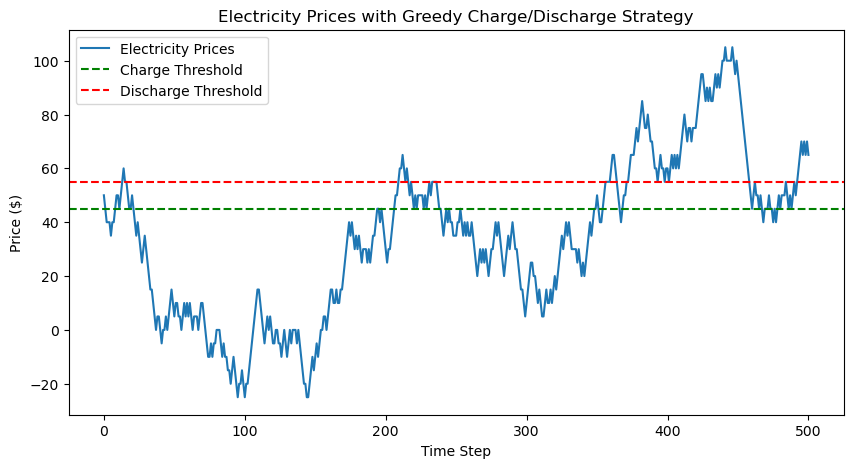

Total Profit from Greedy Strategy: 0


In [28]:
# 🔹 Problem 6: Dynamic Optimization – Battery Scheduling
# Rewbi decides when to charge or discharge a battery to maximize profits.
# Each hour, you can:

# Charge (if price ≤ $40)
# Discharge (if price ≥ $60)
# Do nothing
# Write a greedy algorithm to decide when to charge/discharge for maximum profit over 24 hours, given random price fluctuations.

# 👉 How would you implement this?
# (Hint: Use a simple greedy strategy and later try dynamic programming.)

import numpy as np
import matplotlib.pyplot as plt

def generate_prices(n=500):
    price = 50
    price_history = [price]

    movements = [5,-5,0]
    probabilities = [0.4,0.4,0.2]

    for _ in range(n):
        move = np.random.choice(movements, p = probabilities)
        price += move
        price_history.append(price)

    return price_history


def greedy_battery_strategy(prices, battery_capacity=1):
    battery = 0, # 0 = empty, 1 = charged
    profits = 0

    for i in range(len(prices) - 1):
        if prices[i] <= 40 and battery ==0:
            battery =1
            buy_price = prices[i]
        
        elif prices[i] >= 60 and battery == 1:
            battery = 0
            sell_price = prices[i]
            profits += sell_price-buy_price
    return profits

prices = generate_prices()
greedy_profit = greedy_battery_strategy(prices)

plt.figure(figsize=(10, 5))
plt.plot(prices, label="Electricity Prices")
plt.axhline(y=45, color='g', linestyle='--', label="Charge Threshold")
plt.axhline(y=55, color='r', linestyle='--', label="Discharge Threshold")
plt.xlabel("Time Step")
plt.ylabel("Price ($)")
plt.title("Electricity Prices with Greedy Charge/Discharge Strategy")
plt.legend()
plt.show()

print("Total Profit from Greedy Strategy:", greedy_profit)

In [30]:
import numpy as np
import functools

def generate_prices(n=500):
    price = 50
    price_history = [price]

    movements = [5,-5,0]
    probabilities = [0.4,0.4,0.2]

    for _ in range(n):
        move = np.random.choice(movements, p = probabilities)
        price += move
        price_history.append(price)

    return price_history

def dp_battery_strategy(prices):
    n = len(prices)

    @functools.lru_cache(None)

    def dp(day, battery_state):
        if day >= n:
            return 0
        
        if battery_state == 0: # battery is empty
            charge = -prices[day] + dp(day +1, 1) #buy at price[day]
            skip = dp(day+1,0)
            return max(charge,skip)
        
        else:
            sell = prices[day] + dp(day+1,0)
            hold = dp(day+1,1)
            return max(sell,hold)
    
    return dp(0,0)

prices = generate_prices()
dp_profit = dp_battery_strategy(prices)

# Print result
print("Total Profit from Dynamic Programming Strategy:", dp_profit)


Total Profit from Dynamic Programming Strategy: 990
